In [785]:
#------------------------------Librerias------------------------------#

import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

from numdifftools import Derivative
from scipy.integrate import quad , simpson
from scipy.interpolate import griddata 

import matplotlib.cm as cm
from matplotlib.colors import LogNorm , SymLogNorm , TwoSlopeNorm , LinearSegmentedColormap , Normalize


import warnings
warnings.filterwarnings("error")



#Proyecto final - Metodos Computacionales
## Orly de Jesus Rivera Cruz - 1137977500
## Maria Jose Jaimes Gelvez - 1094247691

# 1. Coordenadas cartesianas

### &nbsp;&nbsp;1.1 Funciones para puntos particulares


In [764]:
#-1.1.1 Campo electrico (QUAD)
def campo_electrico(Funcs , Intervs , Dens , a , b):
    
    """
    
    Esta funcion encuentra el campo electrico tanto en magnitud como
    en dirección en UN SOLO PUNTO. (Ejes cartesianos)

    La funcion es mas precisa por el uso de quad, pero es muy lenta para
    cuestiones iterativas.

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    a:       Componente en x del punto particular                            ---> Float
    b:       Componente en y del punto particular                            ---> Float

    Salidas:
    Ex:   Magnitud de la componente en x del campo electrico                 ---> Float
    Ey:   Magnitud de la componente en y del campo electrico                 ---> Float
    Emag: Magnitud del campo electrico                                       ---> Float

    """

    Ex = 0                                                                            #Generamos las variables para el campo electrico
    Ey = 0
    
    for Func,Interv,Den in zip(Funcs , Intervs , Dens):                               #Iteraciones para la suma del campo electrico  
        #Datos necesarios para el potencial
        K = 8.99e9                                                             
        
        #Funciones necesarias para el potencial
        df = Derivative(Func)                                                         #Funcion derivada
        r   = lambda x : np.sqrt( ( (x-a)**2 + (Func(x) - b)**2 ) )                   #Funcion distancia
        L = lambda x : np.sqrt( (1 + (df(x))**2) )                                    #Funcion longitud de curva
        dEx = lambda x : ( (K)*(Den)*(L(x)) ) * ( (a - x)/(r(x)**3) )                 #Diferencial del campo electrico en x
        dEy = lambda x : ( (K)*(Den)*(L(x)) ) * ( (b - Func(x))/(r(x)**3) )           #Diferencial del campo electrico en y

        #Proceso de integracion con quad
        Ex0 , _ = quad(dEx , Interv[0] , Interv[1])                                   #Integramos para obtener el campo total
        Ey0 , _ = quad(dEy , Interv[0] , Interv[1])
        
        #Suma escalar de las componentes del campo
        Ex += Ex0
        Ey += Ey0
        

    EMag = (Ex**2 + Ey**2)**(1/2)                                                     #Calculamos la magnitud en el punto
    return Ex,Ey,EMag

In [765]:
#-1.1.2 Potencial electrico (QUAD)
def potencial_electrico(Funcs , Intervs , Dens , a , b):
    
    """
    
    Esta funcion encuentra el potencial electrico con respecto al infinito
    en UN SOLO PUNTO. (Ejes cartesianos)

    La funcion es mas precisa por el uso de quad, pero es muy lenta para
    cuestiones iterativas.

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    a:       Componente en x del punto particular                            ---> Float
    b:       Componente en y del punto particular                            ---> Float

    Salidas:
    V:   Magnitud del potencial electrico en ese punto                       ---> Float

    """
    
    V = 0                                                                       #Generamos la variable para el potencial electrico
    
    for Func,Interv,Den in zip(Funcs , Intervs , Dens): #Iteraciones para la suma del potencial electrico  
        #Datos necesarios para el potencial
        K = 8.99e9

        #Funciones necesarias para el potencial
        df = Derivative(Func)                                            #Funcion derivada
        r   = lambda x : np.sqrt( (x-a)**2 + (Func(x) - b)**2 )          #Funcion distancia
        L = lambda x : np.sqrt( (1 + (df(x))**2) )                       #Funcion longitud de curva
        dV = lambda x : ( (K)*(Den)*(L(x)) ) * ( 1/(r(x)) )              #Diferencial de potencial electrico

        #Proceso de integracion con quad
        V0 , _ = quad(dV , Interv[0] , Interv[1])
        #Suma escalar del potencial electrico
        V += V0
        

    return V

### &nbsp;&nbsp;1.2 Funciones para mallas de puntos

In [766]:
#-1.2.1 CALCULO DE LINEAS DE CAMPO ELECTRICO

def lineas_campo_electrico(Funcs, Intervs, Dens, X , Y ):

    """

    Esta funcion encuentra el campo electrico tanto en magnitud como
    en dirección. (Ejes cartesianos)
    
    Al estar la mayoria de los componentes vectorizados hace que pueda
    calcular muchos puntos a la vez.

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    X:       Malla de el eje X donde se encontraran los potenciales.         ---> Tupla (a,b)
    Y:       Malla de el eje Y donde se encontraran los potenciales.         ---> Tupla (a,b)

    Salidas:
    X:    Malla aplanada de todos los puntos usados en el eje X                          ---> Array (<=k**2)
    Y:    Malla aplanada de todos los puntos usados en el eje Y                          ---> Array (<=k**2)
    Ex:   Malla aplanada de los campos en x sobre cada punto coordenado                  ---> Array (<=k**2)
    Ey:   Malla aplanada de los campos en y sobre cada punto coordenado                  ---> Array (<=k**2)
    Emag: Malla aplanada de la magnitud de los campos sobre cada punto coordenado        ---> Array (<=k**2)
    """

    mask = np.zeros_like(X , dtype=bool)                                                        #Se crea una mascara FALSE para hacer filtrado de los 
    cx = (X[0][-1] - X[0][0])*0.01                                                              #Radio de el punto "a la redonda" que seran removidos
    cy = (Y[-1][0] - Y[0][0])*0.01

    for Func, Interv in zip(Funcs, Intervs):                                                    #Se usa un filtro que remueve los puntos cerca de las funciones
        
        InterX = np.linspace(Interv[0],Interv[1],100)                                           #Se define el intervalo donde esta contenida la funcion (Debe que estar bien definida)
        Referenciax = X[0]                                                                      #Columna de referencia de la malla en X
        IntRedondX = Referenciax[np.abs(InterX[:, None] - Referenciax).argmin(axis=1)]          #Se redondea nuestro intervalo en X para que coincida con los valores de la malla en X

        InterY = Func(InterX)                                                                   #Se define el rango donde esta contenida la funcion con respecto a nuestro dominio
        Referenciay = Y[:, 0]                                                                   #Columna de referencia de la malla en Y
        IntRedondY = Referenciay[np.abs(InterY[:, None] - Referenciay).argmin(axis=1)]          #Se redondea nuestro intervalo en Y para que coincida con los valores de la malla en Y

        for x0, y0 in zip(IntRedondX, IntRedondY):                                              #De manera iterativa se retiran los puntos en cada
            x_min, x_max = x0 - cx, x0 + cx                                                     #Se retiran los puntos que esten a dos unidades en cada direccion
            y_min, y_max = y0 - cy, y0 + cy
            mask |= (X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)
        

    X = np.where(mask, np.nan, X)
    Y = np.where(mask, np.nan, Y)
    
    Ex = np.zeros_like(X)                                                               #Generamos una malla de campo electrico en x
    Ey = np.zeros_like(Y)                                                               #Generamos una malla de campo electrico en y

    for Func,Interv,Den in zip(Funcs , Intervs , Dens):                                 #Iteraciones para la suma del campo electrico       
        #Datos necesarios para el campo electrico
        InterX = np.linspace(Interv[0],Interv[1],500)
        K = 8.99e9
        
        #Funciones necesarias para el campo electrico
        df = Derivative(Func)                                                                                       #Funcion derivada
        r   = lambda x : np.sqrt( (x-X)**2 + (Func(x) - Y)**2 )                                                     #Funcion distancia
        L = lambda x : np.sqrt( (1 + (df(x))**2) )                                                                  #Funcion longitud de curva
        dEx = np.vectorize( lambda x : ( (K)*(Den)*(L(x)) ) * ( (X - x)/(r(x)**3) ) , signature="()->(m,n)")        #Diferencial del campo electrico en x (El np.vectorize es para usar los arrays en ella)
        dEy = np.vectorize( lambda x : ( (K)*(Den)*(L(x)) ) * ( (Y - Func(x))/(r(x)**3) ) , signature="()->(m,n)")  #Diferencial del campo electrico en y (El np.vectorize es para usar los arrays en ella)

        #Proceso de integracion con Simpson
        DEX = dEx(InterX)
        DEY = dEy(InterX)

        DEX = np.transpose(DEX, (1, 2, 0))                                              #Rotamos la matriz para obtener los todos diferenciales en cada punto particular
        DEY = np.transpose(DEY, (1, 2, 0))

        Ex0 = simpson(DEX , InterX)                                                     #Integramos para obtener el campo total
        Ey0 = simpson(DEY , InterX)

        #Suma escalar de las componentes del campo
        Ex += Ex0
        Ey += Ey0
    
    Emag = np.sqrt(Ex**2 + Ey**2)                                                       #Calculamos la magnitud en cada punto
    Ex /= Emag                                                                          #Obtenemos el vector unitario del vector en cada punto
    Ey /= Emag

    return X.ravel()[~np.isnan(X.ravel())] , Y.ravel()[~np.isnan(Y.ravel())] , Ex.ravel()[~np.isnan(Ex.ravel())], Ey.ravel()[~np.isnan(Ey.ravel())], Emag.ravel()[~np.isnan(Emag.ravel())]

In [767]:
#-1.2.2 CALCULO DE UNA MALLA DE POTENCIAL ELECTRICO

def potencial_electrico_malla(Funcs, Intervs, Dens, X , Y ):

    """

    Esta funcion encuentra el potencial electrico en una malla de puntos 
    descrita por un intervalo en el eje X y otro intervalo en el eje Y
    (Ejes cartesianos)

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    X:       Malla de el eje X donde se encontraran los potenciales.         ---> Tupla (a,b)
    Y:       Malla de el eje Y donde se encontraran los potenciales.         ---> Tupla (a,b)

    Salidas:
    X: Malla aplanada de todos los puntos usados en el eje X                          ---> Array (<=k**2)
    Y: Malla aplanada de todos los puntos usados en el eje Y                          ---> Array (<=k**2)
    V: Malla aplanada de los potenciales en cada punto coordenado                     ---> Array (<=k**2)

    """
    
    mask = np.zeros_like(X , dtype=bool)                                                        #Se crea una mascara FALSE para hacer filtrado de los 
    tol = 1e-5                                                                                  #Puntos muy cercanos a esta tolerancia seran removidos

    for Func, Interv in zip(Funcs, Intervs):                                                    #Se usa un filtro que remueve los puntos cerca de las funciones
        
        InterX = np.linspace(Interv[0],Interv[1],2000)                                           #Se define el intervalo donde esta contenida la funcion (Debe que estar bien definida)
        Referenciax = X[0]                                                                      #Columna de referencia de la malla en X
        IntRedondX = Referenciax[np.abs(InterX[:, None] - Referenciax).argmin(axis=1)]          #Se redondea nuestro intervalo en X para que coincida con los valores de la malla en X

        InterY = Func(InterX)                                                                   #Se define el intervalo donde esta contenida la funcion (Debe que estar bien definida)
        Referenciay = Y[:, 0]                                                                   #Columna de referencia de la malla en Y
        IntRedondY = Referenciay[np.abs(InterY[:, None] - Referenciay).argmin(axis=1)]          #Se redondea nuestro intervalo en Y para que coincida con los valores de la malla en Y

        for x0, y0 in zip(IntRedondX, IntRedondY):                                              #De manera iterativa se retiran los puntos en cada
            x_min, x_max = x0 - tol, x0 + tol                                                   #Se retiran los puntos que esten a dos unidades en cualquier direccion
            y_min, y_max = y0 - tol, y0 + tol
            mask |= (X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)
        

        X = np.where(mask, np.nan, X)
        Y = np.where(mask, np.nan, Y)
    
    V = np.zeros_like(X)                                                                #Generamos una malla de potencial vacia

    for Func,Interv,Den in zip(Funcs , Intervs , Dens):                                 #Iteraciones para la suma de potenciales       
        
        #Datos necesarios para el potencial
        InterX = np.linspace(Interv[0],Interv[1],500)
        K = 8.99e9
        
        #Funciones necesarias para el potencial
        df = Derivative(Func)                                                                       #Funcion derivada
        r   = lambda x : np.sqrt( (x-X)**2 + (Func(x) - Y)**2 )                                     #Funcion distancia
        L = lambda x : np.sqrt( (1 + (df(x))**2) )                                                  #Funcion longitud de curva
        dV = np.vectorize( lambda x : ( (K)*(Den)*(L(x)) ) * ( 1/(r(x)) ) , signature="()->(m,n)")  #Diferencial de potencial (El np.vectorize es para usar los arrays en ella)
        
        #Proceso de integracion con Simpson
        DV = dV(InterX)
        DV = np.transpose(DV, (1, 2, 0))                                               #Rotamos la matriz para obtener los todos diferenciales en cada punto particular

        V0 = simpson(DV , InterX)                                                      #Integramos para obtener el potencial total
        
        #Suma escalar de los potenciales
        V += V0
    
    return X.ravel()[~np.isnan(X.ravel())] , Y.ravel()[~np.isnan(Y.ravel())] , V.ravel()[~np.isnan(V.ravel())]

### &nbsp;&nbsp;1.3 Graficas

In [768]:
#-1.3.1 Datos

Funciones  = np.array([  lambda x: 0.4*(x**2) , lambda x: -x , lambda x: np.log(10*x) , lambda x:np.exp(0.001*x) , lambda x:40*np.sin(0.1*x)])
Intervalos = np.array([  np.array([-20,20]) , np.array([-75,75]) , np.array([1,100]) , np.array([-75,50]) , np.array([-70,30])])
Densidades = np.array([  1e-5  , 1e-5 , -1e-5 , -1e-5 , -1e-5])


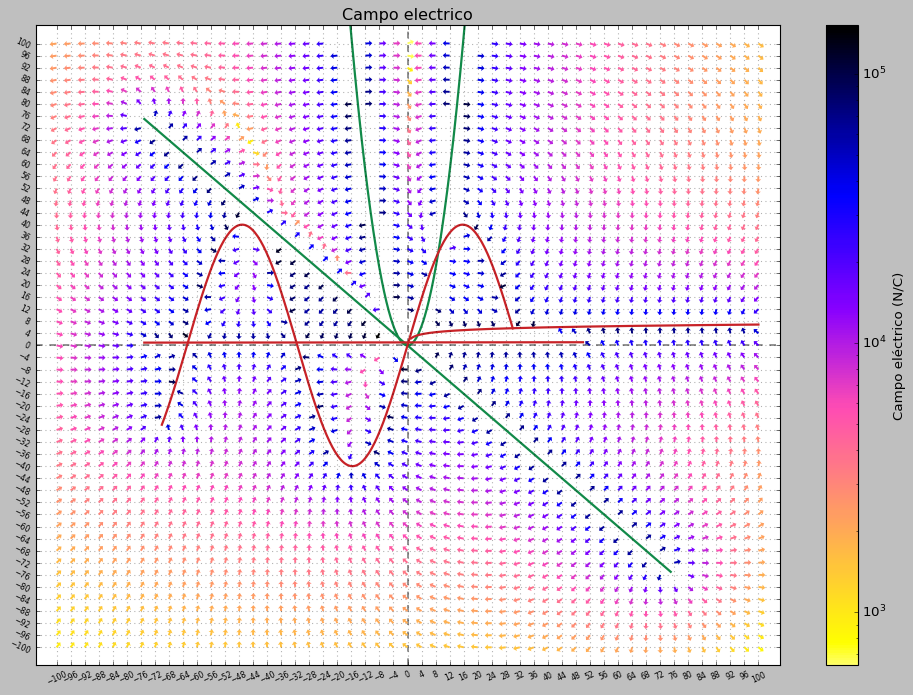

In [769]:
#-1.3.2 LINEAS DE CAMPO ELECTRICO

#-------------------- CALCULO DE LA MALLA VECTORIAL --------------------

#---------- PARAMETROS BASICOS PARA LA MALLA ----------

k = 51                                                                                                       #Numero de puntos que tendra la malla vectorial

x0 = -100                                                                                                    #Limites de la malla vectorial
x1 = 100
y0 = -100
y1 = 100

xi = np.linspace(x0, x1, k)                                                                                  #Creacion de las mallas en los ejes "X" y "Y"
yi = np.linspace(y0, y1, k) 
X , Y = np.meshgrid(xi, yi)     

X_puntos , Y_puntos , Campos_X , Campos_Y , Magnitudes = lineas_campo_electrico(Funciones , Intervalos , Densidades , X , Y )

#---------- PARAMETROS PARA LA ASIGNACION DEL COLOR ----------

Emin = min(Magnitudes)                                                                                       #Normalizacion de las magnitudes para la asignacion del color
Emax = max(Magnitudes)
Norma = LogNorm(vmin=Emin, vmax=Emax)

Mapeo = LinearSegmentedColormap.from_list("half_gnuplot2_r", cm.gnuplot2_r(np.linspace(0.05, 1, 256)))       #Creacion del mapeo de los colores 

#-------------------- GRAFICA DE LAS LINEAS DEL CAMPO ELECTRICO --------------------

#---------- PARAMETROS BASICOS PARA LA GRAFICA ----------

plt.style.use("classic")

plt.figure(figsize=(15, 10))
plt.title("Campo electrico")

plt.axhline(0, c="black", alpha=0.5 , linewidth=1.5 , ls="--")                                               
plt.axvline(0, c="black", alpha=0.5 , linewidth=1.5 , ls="--")

cx = (x1 - x0)*0.03                                                                                          #Extension de la visualizacion para que no salgan vectores recortados
cy = (y1 - y0)*0.03

plt.xlim(x0 - cx, x1 + cx)
plt.ylim(y0 - cy, y1 + cy)

#---------- GRAFICACION DEL CAMPO VECTORIAL ----------

"""
Graficacion de los vectores con su norma modificada dependiendo de los limites de la grafica,
estan coloreados dependiendo la magnitud del campo en ese punto con nuestro colormap y
ajustados de tal manera que su visualizacion sea estetica.

Se seleccionando todos los puntos no descartados con su magnitud modificada para que siempre se
mantenga en proporcion al tamaño de la grafica, con un degradado de color dependiendo de la magnitud
entre mas blanco es poco intenso y entre mas negro es mas intenso

"""

Vectores = plt.quiver(X_puntos, Y_puntos, Campos_X*(x1-x0)/(2*k), Campos_Y*(y1-y0)/(2*k), Magnitudes,       
cmap=Mapeo, norm=Norma, angles="xy", headwidth=3,headlength=1.65,headaxislength = 1.485,                         
scale_units="xy", scale=1, width=0.0026 , zorder=3)                                                         

plt.colorbar(Vectores, label="Campo eléctrico (N/C)")

#---------- GRAFICACION DE LAS LINEAS CARGADAS ----------

for Funcion, Intervalo, Densidad in zip(Funciones, Intervalos, Densidades):                                 #Se grafican todas las funciones dichas con un colormap para diferenciar magnitud lineal de carga

    Norma = SymLogNorm(linthresh=1e-16 , vmin=-1e-3, vmax=1e-3)
    Mapeo = cm.RdYlGn

    Color = Mapeo(Norma(Densidad))

    x = np.linspace(Intervalo[0], Intervalo[1], 250)
    
    plt.plot(x, Funcion(x) , color = Color , linewidth=2)

#---------- PARAMETROS DE LA CUADRICULA ----------

plt.xticks(xi , rotation=25)                                                                                #Se pone una cuadricula fina para mejor visualizacion de las escalas
plt.yticks(yi , rotation=-25)
plt.tick_params(axis="both", labelsize=7)                                                               
plt.grid(color="black", linewidth=1 , alpha=0.3, zorder=1)

plt.show()

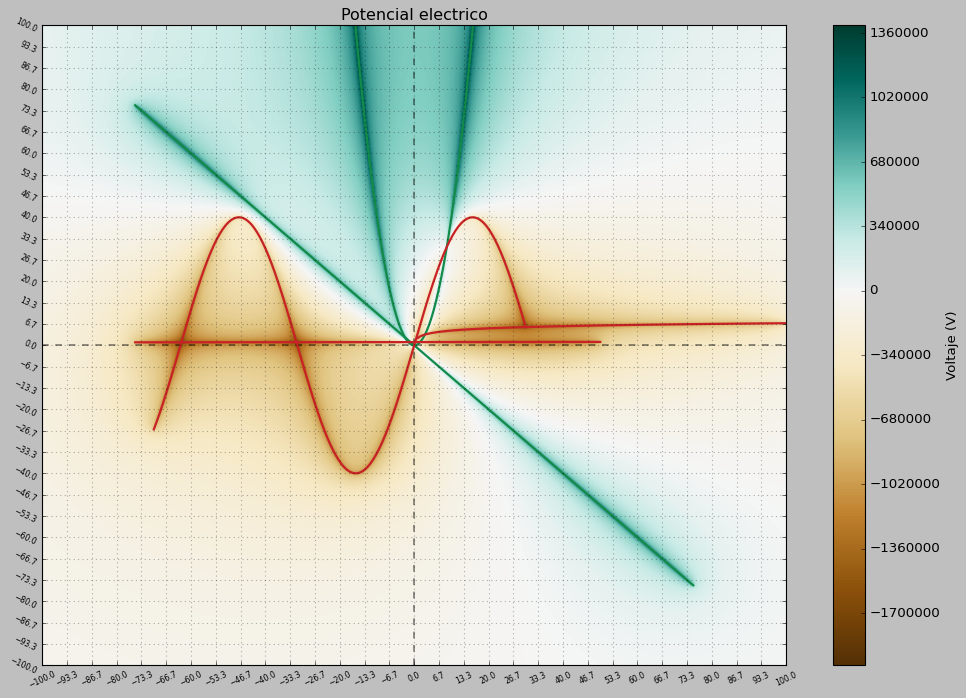

In [770]:
#-1.3.3 MALLA DE POTENCIAL ELECTRICO

#-------------------- CALCULO DE LA MALLA DEL POTENCIAL ELECTRICO --------------------

k = 501                                                                                                      #Numero de puntos que tendra la malla vectorial

x0 = -100                                                                                                    #Limites de la malla vectorial
x1 = 100
y0 = -100
y1 = 100

xi = np.linspace(x0, x1, k)                                                                                  #Creacion de las mallas en los ejes "X" y "Y"
yi = np.linspace(y0, y1, k)
X , Y = np.meshgrid(xi, yi)

X_puntos , Y_puntos , Potenciales = potencial_electrico_malla(Funciones , Intervalos , Densidades , X , Y )

#---------- PARAMETROS PARA LA ASIGNACION DEL COLOR ----------

Coords = np.column_stack((X_puntos, Y_puntos))                                                               #Interpolacion de la malla de potencial con los puntos dados

V_malla = griddata(Coords, Potenciales, (X,Y), method="cubic")

#-------------------- GRAFICA DE LA MALLA DEL POTENCIAL ELECTRICO --------------------

#---------- PARAMETROS BASICOS PARA LA GRAFICA ----------

plt.style.use("classic")

plt.figure(figsize=(15, 10))
plt.title("Potencial electrico")

plt.xlim(x0 , x1)
plt.ylim(y0 , y1)

plt.axhline(0, ls="--", c="black", alpha=0.5 , linewidth=1.5)
plt.axvline(0, ls="--", c="black", alpha=0.5 , linewidth=1.5)

#---------- GRAFICACION DEL CAMPO VECTORIAL ----------

"""
Graficacion de la malla de potencial electrica dependiendo de los valores del potencial,
esto para fijar el cero sin color y que tenga una mejor visualizacion

Una vez determinado los signos del potencial se decide como colorearlo, en este caso los verdes
siempre son potencial positivo y los naranjas potenciales negativo

"""

Vmin = min(Potenciales)
Vmax = max(Potenciales)

if Vmax >= 0 and Vmin >= 0:
    plt.contourf(X, Y, V_malla, 1000, cmap=LinearSegmentedColormap.from_list("half_BrBG", cm.BrBG(np.linspace(0.5,1,256))), vmin=0, vmax=Vmax)
elif Vmax <= 0 and Vmin <= 0:
    plt.contourf(X, Y, V_malla, 1000, cmap=LinearSegmentedColormap.from_list("half_BrBG_pos", cm.BrBG(np.linspace(0, 0.5, 256))), vmin=Vmin, vmax=0)
else:
    Norma = TwoSlopeNorm(vmin=Vmin, vcenter = 0,vmax=Vmax)
    plt.contourf(X, Y, V_malla, 1000, cmap="BrBG", norm = Norma)

plt.colorbar(label="Voltaje (V)")

#---------- GRAFICACION DE LAS LINEAS CARGADAS ----------

for Funcion, Intervalo, Densidad in zip(Funciones, Intervalos, Densidades):                                 #Se grafican todas las funciones dichas con un colormap para diferenciar magnitud lineal de carga

    Norma = SymLogNorm(linthresh=1e-16 , vmin=-1e-3, vmax=1e-3)
    Mapeo = cm.RdYlGn

    Color = Mapeo(Norma(Densidad))

    x = np.linspace(Intervalo[0], Intervalo[1], 250)
    
    plt.plot(x, Funcion(x) , color = Color , linewidth=2)

#---------- PARAMETROS DE LA CUADRICULA ----------

plt.xticks(np.linspace(x0, x1, 31) , rotation=25)                                                           #Se pone una cuadricula fina para mejor visualizacion de las escalas
plt.yticks(np.linspace(y0, y1, 31) , rotation=-25)

plt.tick_params(axis="both", labelsize=7) 

plt.grid(color="black", linewidth=1 , alpha=0.3, zorder=1)
plt.show()



# 2. Coordenadas polares

### &nbsp;&nbsp;2.1 Funciones para puntos particulares


In [771]:
#-2.1.1 Campo electrico (QUAD)
def campo_electrico(Funcs , Intervs , Dens , a , b):
    
    """
    
    Esta funcion encuentra el campo electrico tanto en magnitud como
    en dirección en UN SOLO PUNTO. (Ejes polares)

    La funcion es mas precisa por el uso de quad, pero es muy lenta para
    cuestiones iterativas.

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    a:       Componente en x del punto particular                            ---> Float
    b:       Componente en y del punto particular                            ---> Float

    Salidas:
    Ex:   Magnitud de la componente en x del campo electrico                 ---> Float
    Ey:   Magnitud de la componente en y del campo electrico                 ---> Float
    Emag: Magnitud del campo electrico                                       ---> Float

    """
    if a == 0 and b == 0:
        return "El campo electrico en el 0 no se puede obtener"
    
    Ex = 0                                                                            #Generamos las variables para el campo electrico
    Ey = 0
    
    for Func,Interv,Den in zip(Funcs , Intervs , Dens):                               #Iteraciones para la suma del campo electrico  
        #Datos necesarios para el potencial
        K = 8.99e9                                                             
        
        #Funciones necesarias para el potencial
        df = Derivative(Func)                                                         #Funcion derivada
        r   = lambda θ : np.sqrt( ( (Func(θ)*np.cos(θ) - a)**2 + (Func(θ)*np.sin(θ) - b)**2 ) )                   #Funcion distancia
        L = lambda θ : np.sqrt( ((Func(θ))**2 + (df(θ))**2) )                                    #Funcion longitud de curva
        dEx = lambda θ : ( (K)*(Den)*(L(θ)) ) * ( (a - Func(θ)*np.cos(θ))/(r(θ)**3) )                 #Diferencial del campo electrico en x
        dEy = lambda θ : ( (K)*(Den)*(L(θ)) ) * ( (b - Func(θ)*np.sin(θ))/(r(θ)**3) )           #Diferencial del campo electrico en y

        #Proceso de integracion con quad
        Ex0 , _ = quad(dEx , Interv[0] , Interv[1])                                   #Integramos para obtener el campo total
        Ey0 , _ = quad(dEy , Interv[0] , Interv[1])
        
        #Suma escalar de las componentes del campo
        Ex += Ex0
        Ey += Ey0
        

    EMag = (Ex**2 + Ey**2)**(1/2)                                                     #Calculamos la magnitud en el punto
    return Ex,Ey,EMag

In [772]:
#-2.1.2 Potencial electrico (QUAD)
def potencial_electrico(Funcs , Intervs , Dens , a , b):
    
    """
    
    Esta funcion encuentra el potencial electrico con respecto al infinito
    en UN SOLO PUNTO. (Ejes polares)

    La funcion es mas precisa por el uso de quad, pero es muy lenta para
    cuestiones iterativas.

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    a:       Componente en x del punto particular                            ---> Float
    b:       Componente en y del punto particular                            ---> Float

    Salidas:
    V:   Magnitud del potencial electrico en ese punto                       ---> Float

    """
    
    V = 0                                                                       #Generamos la variable para el potencial electrico
    
    for Func,Interv,Den in zip(Funcs , Intervs , Dens): #Iteraciones para la suma del potencial electrico  
        #Datos necesarios para el potencial
        K = 8.99e9

        #Funciones necesarias para el potencial
        df = Derivative(Func)                                            #Funcion derivada
        r   = lambda θ : np.sqrt( (Func(θ)*np.cos(θ)-a)**2 + (Func(θ)*np.sin(θ) - b)**2 )          #Funcion distancia
        L = lambda θ : np.sqrt( ((Func(θ))**2 + (df(θ))**2) )                       #Funcion longitud de curva
        dV = lambda θ : ( (K)*(Den)*(L(θ)) ) * ( 1/(r(θ)) )              #Diferencial de potencial electrico

        #Proceso de integracion con quad
        V0 , _ = quad(dV , Interv[0] , Interv[1])
        #Suma escalar del potencial electrico
        V += V0
        

    return V

### &nbsp;&nbsp;2.2 Funciones para mallas de puntos

In [773]:
#-2.2.1 CALCULO DE LINEAS DE CAMPO ELECTRICO

def lineas_campo_electrico_po(Funcs, Intervs, Dens, X , Y ):

    """

    Esta funcion encuentra el campo electrico tanto en magnitud como
    en dirección. (Ejes polares)
    
    Al estar la mayoria de los componentes vectorizados hace que pueda
    calcular muchos puntos a la vez.

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    X:       Malla de el eje X donde se encontraran los potenciales.         ---> Tupla (a,b)
    Y:       Malla de el eje Y donde se encontraran los potenciales.         ---> Tupla (a,b)

    Salidas:
    X:    Malla aplanada de todos los puntos usados en el eje X                          ---> Array (<=k**2)
    Y:    Malla aplanada de todos los puntos usados en el eje Y                          ---> Array (<=k**2)
    Ex:   Malla aplanada de los campos en x sobre cada punto coordenado                  ---> Array (<=k**2)
    Ey:   Malla aplanada de los campos en y sobre cada punto coordenado                  ---> Array (<=k**2)
    Emag: Malla aplanada de la magnitud de los campos sobre cada punto coordenado        ---> Array (<=k**2)
    """
    
    mask0 = (X == 0) & (Y == 0)                                                         #Removemos el (0,0) ya que en coordenadas polares su direccion NO esta definida
    X = np.where(mask0, np.nan, X)
    Y = np.where(mask0, np.nan, Y)

    
    mask = np.zeros_like(X , dtype=bool)                                                        #Se crea una mascara FALSE para hacer filtrado de los 
    cx = (X[0][-1] - X[0][0])*0.01                                                              #Radio de el punto "a la redonda" que seran removidos
    cy = (Y[-1][0] - Y[0][0])*0.01

    for Func, Interv in zip(Funcs, Intervs):

        InterΘ = np.linspace(Interv[0],Interv[1],100)                                           #Al ser poalres se definen sus intervalos de angulos y radios
        Radios = Func(InterΘ)                                                                   #Estas las pasaremos a coordenadas cartesianas para obtener una malla rectangular

        InterX = Radios * np.cos(InterΘ)                                                        #Se define el intervalo donde esta contenida la funcion (Debe que estar bien definida)
        Referenciax = X[0]                                                                      # Columna de referencia de la malla en X
        IntRedondX = Referenciax[np.abs(InterX[:, None] - Referenciax).argmin(axis=1)]          #Se redondea nuestro intervalo en X para que coincida con los valores de la malla en X

        InterY = Radios * np.sin(InterΘ)                                                        #Se define el rango donde esta contenida la funcion con respecto a nuestro dominio
        Referenciay = Y[:, 0]  # Columna de referencia de la malla                              #Columna de referencia de la malla en Y
        IntRedondY = Referenciay[np.abs(InterY[:, None] - Referenciay).argmin(axis=1)]          #Se redondea nuestro intervalo en Y para que coincida con los valores de la malla en Y

        for x0, y0 in zip(IntRedondX, IntRedondY):                                              #De manera iterativa se retiran los puntos en cada
            x_min, x_max = x0 - cx, x0 + cx                                                     #Se retiran los puntos que esten a dos unidades en cada direccion
            y_min, y_max = y0 - cy, y0 + cy
            mask |= (X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)
        

    X = np.where(mask, np.nan, X)
    Y = np.where(mask, np.nan, Y)                                                        

    Ex = np.zeros_like(X)                                                               #Generamos una malla de campo electrico en x
    Ey = np.zeros_like(Y)                                                               #Generamos una malla de campo electrico en y

    for Func,Interv,Den in zip(Funcs , Intervs , Dens):                                 #Iteraciones para la suma de del campo electrico       
        #Datos necesarios para el campo electrico
        InterX = np.linspace(Interv[0],Interv[1],500)
        K = 8.99e9
        
        #Funciones necesarias para el campo electrico
        df = Derivative(Func)                                                                                                       #Funcion derivada
        r = lambda θ : np.sqrt( (X - Func(θ) * np.cos(θ))**2 + (Y - Func(θ) * np.sin(θ))**2 )                                       #Funcion distancia
        L = lambda θ : np.sqrt( r(θ)**2 + df(θ)**2 )                                                                                #Funcion longitud de curva
        dEx = np.vectorize( lambda θ : ( (K)*(Den)*(L(θ)) ) * ( (X - Func(θ) * np.cos(θ))/(r(θ)**3) ) , signature="()->(m,n)")      #Diferencial del campo electrico en x (El np.vectorize es para usar los arrays en ella)
        dEy = np.vectorize( lambda θ : ( (K)*(Den)*(L(θ)) ) * ( (Y - Func(θ) * np.sin(θ))/(r(θ)**3) ) , signature="()->(m,n)")      #Diferencial del campo electrico en y (El np.vectorize es para usar los arrays en ella)

        #Proceso de integracion con Simpson
        DEX = dEx(InterX)
        DEY = dEy(InterX)

        DEX = np.transpose(DEX, (1, 2, 0))                                              #Rotamos la matriz para obtener los todos diferenciales en cada punto particular
        DEY = np.transpose(DEY, (1, 2, 0))

        Ex0 = simpson(DEX , InterX)                                                     #Integramos para obtener el campo total
        Ey0 = simpson(DEY , InterX)

        #Suma escalar de las componentes del campo
        Ex += Ex0
        Ey += Ey0
    
    Emag = np.sqrt(Ex**2 + Ey**2)                                                       #Calculamos la magnitud en cada punto
    Ex /= Emag                                                                          #Obtenemos el vector unitario del vector en cada punto
    Ey /= Emag

    return X.ravel()[~np.isnan(X.ravel())] , Y.ravel()[~np.isnan(Y.ravel())] , Ex.ravel()[~np.isnan(Ex.ravel())], Ey.ravel()[~np.isnan(Ey.ravel())], Emag.ravel()[~np.isnan(Emag.ravel())]

In [774]:
#-2.2.2 CALCULO DE UNA MALLA DE POTENCIAL ELECTRICO

def potencial_electrico_malla_po(Funcs, Intervs, Dens, X , Y ):

    """

    Esta funcion encuentra el potencial electrico en una malla de puntos 
    descrita por un intervalo en el eje X y otro intervalo en el eje Y
    (Ejes polares)

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    X:       Malla de el eje X donde se encontraran los potenciales.         ---> Tupla (a,b)
    Y:       Malla de el eje Y donde se encontraran los potenciales.         ---> Tupla (a,b)

    Salidas:
    X: Malla aplanada de todos los puntos usados en el eje X                          ---> Array (<=k**2)
    Y: Malla aplanada de todos los puntos usados en el eje Y                          ---> Array (<=k**2)
    V: Malla aplanada de los potenciales en cada punto coordenado                     ---> Array (<=k**2)

    """

    mask0 = (X == 0) & (Y == 0)                                                         #Removemos el (0,0) ya que en coordenadas polares su direccion NO esta definida
    X = np.where(mask0, np.nan, X)
    Y = np.where(mask0, np.nan, Y)

    
    mask = np.zeros_like(X , dtype=bool)                                                        #Se crea una mascara FALSE para hacer filtrado de los 
    tol = 1e-5                                                                                  #Puntos muy cercanos a esta tolerancia seran removidos

    for Func, Interv in zip(Funcs, Intervs):

        InterΘ = np.linspace(Interv[0],Interv[1],1000)                                           #Al ser poalres se definen sus intervalos de angulos y radios
        Radios = Func(InterΘ)                                                                   #Estas las pasaremos a coordenadas cartesianas para obtener una malla rectangular

        InterX = Radios * np.cos(InterΘ)                                                        #Se define el intervalo donde esta contenida la funcion (Debe que estar bien definida)
        Referenciax = X[0]                                                                      # Columna de referencia de la malla en X
        IntRedondX = Referenciax[np.abs(InterX[:, None] - Referenciax).argmin(axis=1)]          #Se redondea nuestro intervalo en X para que coincida con los valores de la malla en X

        InterY = Radios * np.sin(InterΘ)                                                        #Se define el rango donde esta contenida la funcion con respecto a nuestro dominio
        Referenciay = Y[:, 0]  # Columna de referencia de la malla                              #Columna de referencia de la malla en Y
        IntRedondY = Referenciay[np.abs(InterY[:, None] - Referenciay).argmin(axis=1)]          #Se redondea nuestro intervalo en Y para que coincida con los valores de la malla en Y

        for x0, y0 in zip(IntRedondX, IntRedondY):                                              #De manera iterativa se retiran los puntos en cada
            x_min, x_max = x0 - tol, x0 + tol                                                   #Se retiran los puntos que esten a dos unidades en cada direccion
            y_min, y_max = y0 - tol, y0 + tol
            mask |= (X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)
        

    X = np.where(mask, np.nan, X)
    Y = np.where(mask, np.nan, Y)   
    

    V = np.zeros_like(X)                                                               #Generamos una malla de campo electrico en x

    for Func,Interv,Den in zip(Funcs , Intervs , Dens):                                #Iteraciones para la suma de del campo electrico       
        #Datos necesarios para el potencial
        InterX = np.linspace(Interv[0],Interv[1],1000)
        K = 8.99e9
        
        #Funciones necesarias para el potencial
        df = Derivative(Func)                                                                           #Funcion derivada
        r = lambda θ : np.sqrt( ( X - (Func(θ) * np.cos(θ)) )**2 + ( Y - (Func(θ) * np.sin(θ)) )**2 )   #Funcion distancia
        L = lambda θ : np.sqrt( Func(θ)**2 + df(θ)**2 )                                                 #Funcion longitud de curva
        dV = np.vectorize( lambda θ : ( (K)*(Den)*(L(θ)) ) * ( 1/r(θ) ) , signature="()->(m,n)")        #Diferencial del campo electrico en x (El np.vectorize es para usar los arrays en ella)

        #Proceso de integracion con Simpson
        DV = dV(InterX)
        DV = np.transpose(DV, (1, 2, 0))                                              #Rotamos la matriz para obtener los todos diferenciales en cada punto particular

        V0 = simpson(DV , InterX)                                                     #Integramos para obtener el campo total

        #Suma escalar de las componentes del campo
        V += V0

    return X.ravel()[~np.isnan(X.ravel())] , Y.ravel()[~np.isnan(Y.ravel())] , V.ravel()[~np.isnan(V.ravel())]

### &nbsp;&nbsp;2.3 Graficas

In [775]:
#-2.3.1 Datos

Funcionespo  = np.array([ lambda θ: 50*np.cos(θ),lambda θ: 30*np.sin(2*θ) + 40,lambda θ: 20*np.cos(θ) + 20*np.sin(θ)])

Intervalospo = np.array([ np.array([0 , np.pi]), np.array([0 , 2*np.pi]), np.array([0 , 2*np.pi]) ])

Densidadespo = np.array([1e-9, -5e-10, 2e-9])


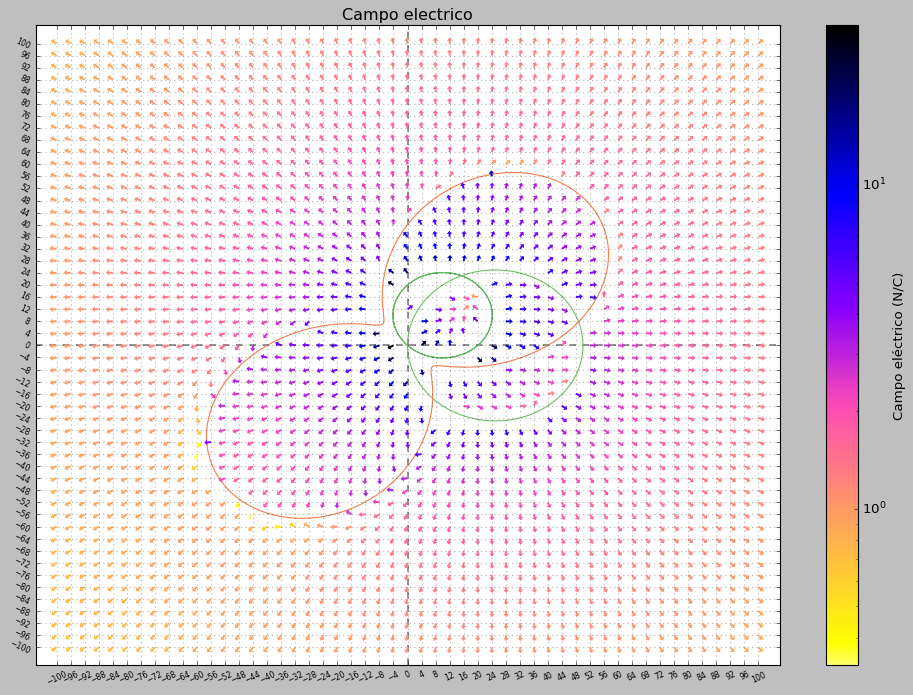

In [776]:
#-2.3.2 LINEAS DE CAMPO ELECTRICO

#-------------------- CALCULO DE LA MALLA VECTORIAL --------------------

#---------- PARAMETROS BASICOS PARA LA MALLA ----------

k = 51                                                                                                       #Numero de puntos que tendra la malla vectorial

x0 = -100                                                                                                    #Limites de la malla vectorial
x1 = 100
y0 = -100
y1 = 100

xi = np.linspace(x0, x1, k)                                                                                  #Creacion de las mallas en los ejes "X" y "Y"
yi = np.linspace(y0, y1, k) 
X , Y = np.meshgrid(xi, yi)     

X_puntos , Y_puntos , Campos_X , Campos_Y , Magnitudes = lineas_campo_electrico_po(Funcionespo , Intervalospo , Densidadespo , X , Y )

#---------- PARAMETROS PARA LA ASIGNACION DEL COLOR ----------

Emin = min(Magnitudes)                                                                                       #Normalizacion de las magnitudes para la asignacion del color
Emax = max(Magnitudes)
Norma = LogNorm(vmin=Emin, vmax=Emax)

Mapeo = LinearSegmentedColormap.from_list("half_gnuplot2_r", cm.gnuplot2_r(np.linspace(0.05, 1, 256)))       #Creacion del mapeo de los colores 

#-------------------- GRAFICA DE LAS LINEAS DEL CAMPO ELECTRICO --------------------

#---------- PARAMETROS BASICOS PARA LA GRAFICA ----------

plt.style.use("classic")

plt.figure(figsize=(15, 10))
plt.title("Campo electrico")

plt.axhline(0, c="black", alpha=0.5 , linewidth=1.5 , ls="--")                                               
plt.axvline(0, c="black", alpha=0.5 , linewidth=1.5 , ls="--")

cx = (x1 - x0)*0.03                                                                                          #Extension de la visualizacion para que no salgan vectores recortados
cy = (y1 - y0)*0.03

plt.xlim(x0 - cx, x1 + cx)
plt.ylim(y0 - cy, y1 + cy)

#---------- GRAFICACION DEL CAMPO VECTORIAL ----------

"""
Graficacion de los vectores con su norma modificada dependiendo de los limites de la grafica,
estan coloreados dependiendo la magnitud del campo en ese punto con nuestro colormap y
ajustados de tal manera que su visualizacion sea estetica.
"""

Vectores = plt.quiver(X_puntos, Y_puntos, Campos_X*(x1-x0)/(2*k), Campos_Y*(y1-y0)/(2*k), Magnitudes,       
cmap=Mapeo, norm=Norma, angles="xy", headwidth=3,headlength=1.65,headaxislength = 1.485,                         
scale_units="xy", scale=1, width=0.0026 , zorder=3)                                                         

plt.colorbar(Vectores, label="Campo eléctrico (N/C)")

#---------- GRAFICACION DE LAS LINEAS CARGADAS ----------

for Funcion, Intervalo, Densidad in zip(Funcionespo, Intervalospo, Densidadespo):                                 #Se grafican todas las funciones dichas con un colormap para diferenciar magnitud lineal de carga

    Norma = SymLogNorm(linthresh=1e-16 , vmin=-1e-3, vmax=1e-3)
    Mapeo = cm.RdYlGn

    Color = Mapeo(Norma(Densidad))

    θ = np.linspace(Intervalo[0], Intervalo[1], 1000)
    
    plt.plot(Funcion(θ) * np.cos(θ), Funcion(θ) * np.sin(θ) , color = Color )

#---------- PARAMETROS DE LA CUADRICULA ----------

plt.xticks(xi , rotation=25)                                                                                #Se pone una cuadricula fina para mejor visualizacion de las escalas
plt.yticks(yi , rotation=-25)
plt.tick_params(axis="both", labelsize=7)                                                               
plt.grid(color="black", linewidth=1 , alpha=0.3, zorder=1)

plt.show()

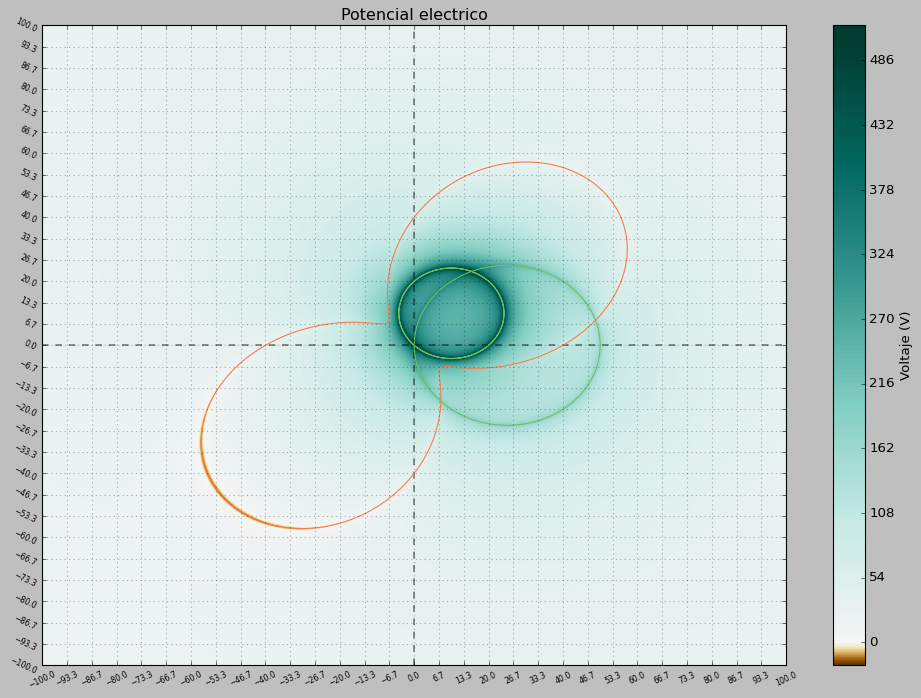

In [777]:
#-2.3.3 MALLA DE POTENCIAL ELECTRICO

#-------------------- CALCULO DE LA MALLA DEL POTENCIAL ELECTRICO --------------------

k = 501                                                                                                      #Numero de puntos que tendra la malla vectorial

x0 = -100                                                                                                    #Limites de la malla vectorial
x1 = 100
y0 = -100
y1 = 100

xi = np.linspace(x0, x1, k)                                                                                  #Creacion de las mallas en los ejes "X" y "Y"
yi = np.linspace(y0, y1, k)
X , Y = np.meshgrid(xi, yi)

X_puntos , Y_puntos , Potenciales = potencial_electrico_malla_po(Funcionespo , Intervalospo , Densidadespo , X , Y )
#---------- PARAMETROS PARA LA ASIGNACION DEL COLOR ----------

Coords = np.column_stack((X_puntos, Y_puntos))                                                               #Interpolacion de la malla de potencial con los puntos dados

V_malla = griddata(Coords, Potenciales, (X,Y), method="cubic")

#-------------------- GRAFICA DE LA MALLA DEL POTENCIAL ELECTRICO --------------------

#---------- PARAMETROS BASICOS PARA LA GRAFICA ----------

plt.style.use("classic")

plt.figure(figsize=(15, 10))
plt.title("Potencial electrico")

plt.xlim(x0 , x1)
plt.ylim(y0 , y1)

plt.axhline(0, ls="--", c="black", alpha=0.5 , linewidth=1.5)
plt.axvline(0, ls="--", c="black", alpha=0.5 , linewidth=1.5)

#---------- GRAFICACION DEL CAMPO VECTORIAL ----------

"""
Graficacion de la malla de potencial electrica dependiendo de los valores del potencial,
esto para fijar el cero sin color y que tenga una mejor visualizacion
"""

Vmin = min(Potenciales)
Vmax = max(Potenciales)

if Vmax >= 0 and Vmin >= 0:
    plt.contourf(X, Y, V_malla, 100, cmap=LinearSegmentedColormap.from_list("half_BrBG", cm.BrBG(np.linspace(0.5,1,256))), vmin=0, vmax=Vmax)
elif Vmax <= 0 and Vmin <= 0:
    plt.contourf(X, Y, V_malla, 1000, cmap=LinearSegmentedColormap.from_list("half_BrBG_pos", cm.BrBG(np.linspace(0, 0.5, 256))), vmin=Vmin, vmax=0)
else:
    Norma = TwoSlopeNorm(vmin=Vmin, vcenter = 0,vmax=Vmax)
    plt.contourf(X, Y, V_malla, 1000, cmap="BrBG", norm = Norma)

plt.colorbar(label="Voltaje (V)")

#---------- GRAFICACION DE LAS LINEAS CARGADAS ----------

for Funcion, Intervalo, Densidad in zip(Funcionespo, Intervalospo, Densidadespo):                                 #Se grafican todas las funciones dichas con un colormap para diferenciar magnitud lineal de carga

    Norma = SymLogNorm(linthresh=1e-16 , vmin=-1e-3, vmax=1e-3)
    Mapeo = cm.RdYlGn

    Color = Mapeo(Norma(Densidad))

    θ = np.linspace(Intervalo[0], Intervalo[1], 1000)
    
    plt.plot(Funcion(θ) * np.cos(θ), Funcion(θ) * np.sin(θ) , color = Color )

#---------- PARAMETROS DE LA CUADRICULA ----------

plt.xticks(np.linspace(x0, x1, 31) , rotation=25)                                                                                #Se pone una cuadricula fina para mejor visualizacion de las escalas
plt.yticks(np.linspace(y0, y1, 31) , rotation=-25)

plt.tick_params(axis="both", labelsize=7) 
plt.grid(color="black", linewidth=1 , alpha=0.3, zorder=1)
plt.show()

# 3. Funciones parametricas

### &nbsp;&nbsp;3.1 Funciones para puntos particulares


In [778]:
#-3.1.1 Campo electrico (QUAD)
def campo_electrico(Funcs , Intervs , Dens , a , b):
    
    """
    
    Esta funcion encuentra el campo electrico tanto en magnitud como
    en dirección en UN SOLO PUNTO. (Funcion parametrica)

    La funcion es mas precisa por el uso de quad, pero es muy lenta para
    cuestiones iterativas.

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    a:       Componente en x del punto particular                            ---> Float
    b:       Componente en y del punto particular                            ---> Float

    Salidas:
    Ex:   Magnitud de la componente en x del campo electrico                 ---> Float
    Ey:   Magnitud de la componente en y del campo electrico                 ---> Float
    Emag: Magnitud del campo electrico                                       ---> Float

    """
    if a == 0 and b == 0:
        return "El campo electrico en el 0 no se puede obtener"
    
    Ex = 0                                                                            #Generamos las variables para el campo electrico
    Ey = 0
    
    for Func,Interv,Den in zip(Funcs , Intervs , Dens):                               #Iteraciones para la suma del campo electrico  
        #Datos necesarios para el potencial
        K = 8.99e9                                                             
        
        #Funciones necesarias para el potencial
        dfx = Derivative(Func[0])                                                         #Funcion derivada
        dfy = Derivative(Func[1]) 
        r   = lambda t : np.sqrt( ( Func[0](t) - a)**2 + (Func[1](t) - b)**2 )                    #Funcion distancia
        L = lambda t : np.sqrt( ((dfx(t))**2 + (dfy(t))**2) )                                    #Funcion longitud de curva
        dEx = lambda t : ( (K)*(Den)*(L(t)) ) * ( (a - Func(t)[0])/(r(t)**3) )                 #Diferencial del campo electrico en x
        dEy = lambda t : ( (K)*(Den)*(L(t)) ) * ( (b - Func(t)[1])/(r(t)**3) )           #Diferencial del campo electrico en y

        #Proceso de integracion con quad
        Ex0 , _ = quad(dEx , Interv[0] , Interv[1])                                   #Integramos para obtener el campo total
        Ey0 , _ = quad(dEy , Interv[0] , Interv[1])
        
        #Suma escalar de las componentes del campo
        Ex += Ex0
        Ey += Ey0
        

    EMag = (Ex**2 + Ey**2)**(1/2)                                                     #Calculamos la magnitud en el punto
    return Ex,Ey,EMag

In [779]:
#-3.1.2 Potencial electrico (QUAD)
def potencial_electrico(Funcs , Intervs , Dens , a , b):
    
    """
    
    Esta funcion encuentra el potencial electrico con respecto al infinito
    en UN SOLO PUNTO. (Funcion parametrica)

    La funcion es mas precisa por el uso de quad, pero es muy lenta para
    cuestiones iterativas.

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    a:       Componente en x del punto particular                            ---> Float
    b:       Componente en y del punto particular                            ---> Float

    Salidas:
    V:   Magnitud del potencial electrico en ese punto                       ---> Float

    """
    
    V = 0                                                                       #Generamos la variable para el potencial electrico
    
    for Func,Interv,Den in zip(Funcs , Intervs , Dens): #Iteraciones para la suma del potencial electrico  
        #Datos necesarios para el potencial
        K = 8.99e9

        #Funciones necesarias para el potencial
        dfx = Derivative(Func[0])                                            #Funcion derivada
        dfy = Derivative(Func[1])
        r   = lambda t : np.sqrt( (Func[0](t)-a)**2 + (Func[1](t) - b)**2 )          #Funcion distancia
        L = lambda t : np.sqrt( ((dfx(t))**2 + (dfy(t))**2) )                       #Funcion longitud de curva
        dV = lambda t : ( (K)*(Den)*(L(t)) ) * ( 1/(r(t)) )              #Diferencial de potencial electrico

        #Proceso de integracion con quad
        V0 , _ = quad(dV , Interv[0] , Interv[1])
        #Suma escalar del potencial electrico
        V += V0
        

    return V

### &nbsp;&nbsp;3.2 Funciones para mallas de puntos

In [780]:
#-3.2.1 CALCULO DE LINEAS DE CAMPO ELECTRICO

def lineas_campo_electrico_pa(Funcs, Intervs, Dens, X , Y ):

    """

    Esta funcion encuentra el campo electrico tanto en magnitud como
    en dirección. (Ejes cartesianos)
    
    Al estar la mayoria de los componentes vectorizados hace que pueda
    calcular muchos puntos a la vez.

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    X:       Malla de el eje X donde se encontraran los potenciales.         ---> Tupla (a,b)
    Y:       Malla de el eje Y donde se encontraran los potenciales.         ---> Tupla (a,b)

    Salidas:
    X:    Malla aplanada de todos los puntos usados en el eje X                          ---> Array (<=k**2)
    Y:    Malla aplanada de todos los puntos usados en el eje Y                          ---> Array (<=k**2)
    Ex:   Malla aplanada de los campos en x sobre cada punto coordenado                  ---> Array (<=k**2)
    Ey:   Malla aplanada de los campos en y sobre cada punto coordenado                  ---> Array (<=k**2)
    Emag: Malla aplanada de la magnitud de los campos sobre cada punto coordenado        ---> Array (<=k**2)
    """

    mask = np.zeros_like(X , dtype=bool)                                                        #Se crea una mascara FALSE para hacer filtrado de los 
    cx = (X[0][-1] - X[0][0])*0.01                                                              #Radio de el punto "a la redonda" que seran removidos
    cy = (Y[-1][0] - Y[0][0])*0.01

    for Func, Interv in zip(Funcs, Intervs):                                                    #Se usa un filtro que remueve los puntos cerca de las funciones
        InterT = np.linspace(Interv[0] , Interv[1],1000)                                             #Se define el dominio del parametro (Debe que estar bien definida)

        InterX = Func[0](InterT)                                                                #Se define el rango en X donde esta contenida la funcion con respecto a nuestro dominio
        Referenciax = X[0]                                                                      #Columna de referencia de la malla en X
        IntRedondX = Referenciax[np.abs(InterX[:, None] - Referenciax).argmin(axis=1)]          #Se redondea nuestro intervalo en X para que coincida con los valores de la malla en X

        InterY = Func[1](InterT)                                                                #Se define el rango en Y donde esta contenida la funcion con respecto a nuestro dominio
        Referenciay = Y[:, 0]                                                                   #Columna de referencia de la malla en Y
        IntRedondY = Referenciay[np.abs(InterY[:, None] - Referenciay).argmin(axis=1)]          #Se redondea nuestro intervalo en Y para que coincida con los valores de la malla en Y

        for x0, y0 in zip(IntRedondX, IntRedondY):                                              #De manera iterativa se retiran los puntos en cada
            x_min, x_max = x0 - cx, x0 + cx                                                     #Se retiran los puntos que esten a dos unidades en cada direccion
            y_min, y_max = y0 - cy, y0 + cy
            mask |= (X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)
        

    X = np.where(mask, np.nan, X)
    Y = np.where(mask, np.nan, Y)                                                        
    
    Ex = np.zeros_like(X)                                                               #Generamos una malla de campo electrico en x
    Ey = np.zeros_like(Y)                                                               #Generamos una malla de campo electrico en y

    for Func,Interv,Den in zip(Funcs , Intervs , Dens):                                 #Iteraciones para la suma de del campo electrico       
        #Datos necesarios para el potencial
        InterT = np.linspace(Interv[0],Interv[1],500)
        K = 8.99e9
        
        #Funciones necesarias para el potencial
        dfx = Derivative(Func[0])                                                                                            #Funcion derivada con respecto a X
        dfy = Derivative(Func[1])                                                                                            #Funcion derivada con respecto a Y
        r = lambda t : np.sqrt( (X - Func[0](t))**2 + (Y - Func[1](t) )**2 )                                                 #Funcion distancia
        L = lambda t : np.sqrt( dfx(t)**2 + dfy(t)**2 )                                                                      #Funcion longitud de curva
        dEx = np.vectorize( lambda t : ( (K)*(Den)*(L(t)) ) * ( (X - Func[0](t))/(r(t)**3) ) , signature="()->(m,n)")        #Diferencial del campo electrico en x (El np.vectorize es para usar los arrays en ella)
        dEy = np.vectorize( lambda t : ( (K)*(Den)*(L(t)) ) * ( (Y - Func[1](t))/(r(t)**3) ) , signature="()->(m,n)")        #Diferencial del campo electrico en y (El np.vectorize es para usar los arrays en ella)

        #Proceso de integracion con Simpson
        DEX = dEx(InterT)
        DEY = dEy(InterT)

        DEX = np.transpose(DEX, (1, 2, 0))                                              #Rotamos la matriz para obtener los todos diferenciales en cada punto particular
        DEY = np.transpose(DEY, (1, 2, 0))

        Ex0 = simpson(DEX , InterT)                                                     #Integramos para obtener el campo total
        Ey0 = simpson(DEY , InterT)

        #Suma escalar de las componentes del campo
        Ex += Ex0
        Ey += Ey0
    
    Emag = np.sqrt(Ex**2 + Ey**2)                                                       #Calculamos la magnitud en cada punto
    Ex /= Emag                                                                          #Obtenemos el vector unitario del vector en cada punto
    Ey /= Emag

    return X.ravel()[~np.isnan(X.ravel())] , Y.ravel()[~np.isnan(Y.ravel())] , Ex.ravel()[~np.isnan(Ex.ravel())], Ey.ravel()[~np.isnan(Ey.ravel())], Emag.ravel()[~np.isnan(Emag.ravel())]

In [781]:
#-3.2.2 CALCULO DE UNA MALLA DE POTENCIAL ELECTRICO

def potencial_electrico_malla_p(Funcs, Intervs, Dens, X , Y ):

    """

    Esta funcion encuentra el potencial electrico en una malla de puntos 
    descrita por un intervalo en el eje X y otro intervalo en el eje Y
    (Ejes cartesianos)

    Entrada:

    Funcs:   Funciones que describiran las lineas cargadas.                  ---> 1d-Array (n)
    Intervs: Intervalos por donde se dibujaran las lineas.                   ---> 1d-Array (n)
    Dens:    Densidades lineales de carga que obtendra cada linea.           ---> 1d-Array (n)
    X:       Malla de el eje X donde se encontraran los potenciales.         ---> Tupla (a,b)
    Y:       Malla de el eje Y donde se encontraran los potenciales.         ---> Tupla (a,b)

    Salidas:
    X: Malla aplanada de todos los puntos usados en el eje X                          ---> Array (<=k**2)
    Y: Malla aplanada de todos los puntos usados en el eje Y                          ---> Array (<=k**2)
    V: Malla aplanada de los potenciales en cada punto coordenado                     ---> Array (<=k**2)

    """
    
    mask = np.zeros_like(X , dtype=bool)                                                        #Se crea una mascara FALSE para hacer filtrado de los 
    tol = 1e-5                                                                                  #Puntos cercanos a esta tolerancia seran removidos

    for Func, Interv in zip(Funcs, Intervs):                                                    #Se usa un filtro que remueve los puntos cerca de las funciones
        InterT = np.linspace(Interv[0] , Interv[1],1000)                                             #Se define el dominio del parametro (Debe que estar bien definida)

        InterX = Func[0](InterT)                                                                #Se define el rango en X donde esta contenida la funcion con respecto a nuestro dominio
        Referenciax = X[0]                                                                      #Columna de referencia de la malla en X
        IntRedondX = Referenciax[np.abs(InterX[:, None] - Referenciax).argmin(axis=1)]          #Se redondea nuestro intervalo en X para que coincida con los valores de la malla en X

        InterY = Func[1](InterT)                                                                #Se define el rango en Y donde esta contenida la funcion con respecto a nuestro dominio
        Referenciay = Y[:, 0]                                                                   #Columna de referencia de la malla en Y
        IntRedondY = Referenciay[np.abs(InterY[:, None] - Referenciay).argmin(axis=1)]          #Se redondea nuestro intervalo en Y para que coincida con los valores de la malla en Y

        for x0, y0 in zip(IntRedondX, IntRedondY):                                              #De manera iterativa se retiran los puntos en cada
            x_min, x_max = x0 - tol, x0 + tol                                                     #Se retiran los puntos que esten a dos unidades en cada direccion
            y_min, y_max = y0 - tol, y0 + tol
            mask |= (X >= x_min) & (X <= x_max) & (Y >= y_min) & (Y <= y_max)
        

    X = np.where(mask, np.nan, X)
    Y = np.where(mask, np.nan, Y)

    V = np.zeros_like(X)                                                                #Generamos una malla de campo electrico en x

    for Func,Interv,Den in zip(Funcs , Intervs , Dens):                                 #Iteraciones para la suma de del campo electrico       
        #Datos necesarios para el potencial
        InterT = np.linspace(Interv[0],Interv[1],1000)
        K = 8.99e9
        
        #Funciones necesarias para el potencial
        dfx = Derivative(Func[0])                                                                          #Funcion derivada con respecto a X
        dfy = Derivative(Func[1])                                                                          #Funcion derivada con respecto a Y
        r = lambda t : np.sqrt( (X - Func[0](t))**2 + (Y - Func[1](t) )**2 )                               #Funcion distancia
        L = lambda t : np.sqrt( dfx(t)**2 + dfy(t)**2 )                                                    #Funcion longitud de curva
        dV = np.vectorize( lambda t : ( (K)*(Den)*(L(t)) ) * ( 1/r(t) ) , signature="()->(m,n)")           #Diferencial del campo electrico en x (El np.vectorize es para usar los arrays en ella)

        #Proceso de integracion con Simpson
        DV = dV(InterT)
        DV = np.transpose(DV, (1, 2, 0))                                              #Rotamos la matriz para obtener los todos diferenciales en cada punto particular

        V0 = simpson(DV , InterT)                                                     #Integramos para obtener el campo total

        #Suma escalar de las componentes del campo
        V += V0

    return X.ravel()[~np.isnan(X.ravel())] , Y.ravel()[~np.isnan(Y.ravel())] , V.ravel()[~np.isnan(V.ravel())]

### &nbsp;&nbsp;3.3 Graficas

In [782]:
#-3.3.1 Datos

Funcionespa  = np.array([ [lambda t: np.cos(t),lambda t: np.sin(2*t)], [lambda t: np.cos(t),lambda t: 3*np.sin(t)], [lambda t: 2*np.cos(t),lambda t: t*np.sin(t)] ])
Intervalospa = np.array([ np.array([0,2*np.pi]), np.array([0,2*np.pi]), np.array([0,4*np.pi]) ])
Densidadespa = np.array([ 1e-4, 2e-4, -1.5e-4 ])

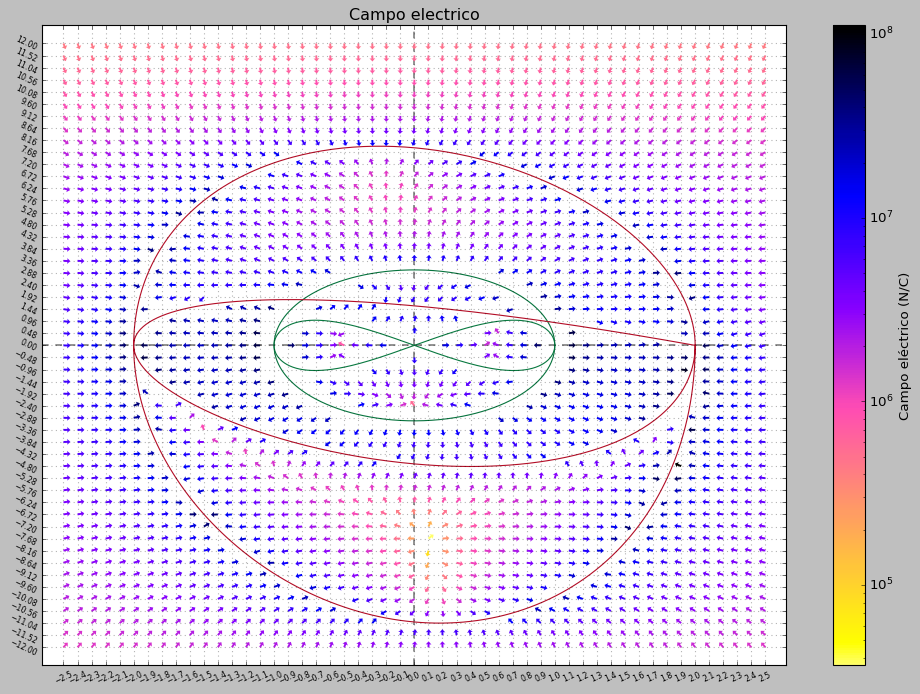

In [783]:
#-3.3.2 LINEAS DE CAMPO ELECTRICO

#-------------------- CALCULO DE LA MALLA VECTORIAL --------------------

#---------- PARAMETROS BASICOS PARA LA MALLA ----------

k = 51                                                                                                       #Numero de puntos que tendra la malla vectorial

x0 = -2.5                                                                                                    #Limites de la malla vectorial
x1 = 2.5
y0 = -12
y1 = 12

xi = np.linspace(x0, x1, k)                                                                                  #Creacion de las mallas en los ejes "X" y "Y"
yi = np.linspace(y0, y1, k) 
X , Y = np.meshgrid(xi, yi)     

X_puntos , Y_puntos , Campos_X , Campos_Y , Magnitudes = lineas_campo_electrico_pa(Funcionespa , Intervalospa , Densidadespa , X , Y )

#---------- PARAMETROS PARA LA ASIGNACION DEL COLOR ----------

Emin = min(Magnitudes)                                                                                       #Normalizacion de las magnitudes para la asignacion del color
Emax = max(Magnitudes)
Norma = LogNorm(vmin=Emin, vmax=Emax)

Mapeo = LinearSegmentedColormap.from_list("half_gnuplot2_r", cm.gnuplot2_r(np.linspace(0.05, 1, 256)))       #Creacion del mapeo de los colores 

#-------------------- GRAFICA DE LAS LINEAS DEL CAMPO ELECTRICO --------------------

#---------- PARAMETROS BASICOS PARA LA GRAFICA ----------

plt.style.use("classic")

plt.figure(figsize=(15, 10))
plt.title("Campo electrico")

plt.axhline(0, c="black", alpha=0.5 , linewidth=1.5 , ls="--")                                               
plt.axvline(0, c="black", alpha=0.5 , linewidth=1.5 , ls="--")

cx = (x1 - x0)*0.03                                                                                          #Extension de la visualizacion para que no salgan vectores recortados
cy = (y1 - y0)*0.03

plt.xlim(x0 - cx, x1 + cx)
plt.ylim(y0 - cy, y1 + cy)

#---------- GRAFICACION DEL CAMPO VECTORIAL ----------

"""
Graficacion de los vectores con su norma modificada dependiendo de los limites de la grafica,
estan coloreados dependiendo la magnitud del campo en ese punto con nuestro colormap y
ajustados de tal manera que su visualizacion sea estetica.
"""

Vectores = plt.quiver(X_puntos, Y_puntos, Campos_X*(x1-x0)/(2*k), Campos_Y*(y1-y0)/(2*k), Magnitudes,       
cmap=Mapeo, norm=Norma, angles="xy", headwidth=3,headlength=1.65,headaxislength = 1.485,                         
scale_units="xy", scale=1, width=0.0026 , zorder=3)                                                         

plt.colorbar(Vectores, label="Campo eléctrico (N/C)")

#---------- GRAFICACION DE LAS LINEAS CARGADAS ----------

for Funcion, Intervalo, Densidad in zip(Funcionespa, Intervalospa, Densidadespa):                                 #Se grafican todas las funciones dichas con un colormap para diferenciar magnitud lineal de carga

    Norma = SymLogNorm(linthresh=1e-16 , vmin=-1e-3, vmax=1e-3)
    Mapeo = cm.RdYlGn

    Color = Mapeo(Norma(Densidad))

    t = np.linspace(Intervalo[0], Intervalo[1], 1000)
    plt.plot(Funcion[0](t), Funcion[1](t) , color = Color )

#---------- PARAMETROS DE LA CUADRICULA ----------

plt.xticks(xi , rotation=25)                                                                                #Se pone una cuadricula fina para mejor visualizacion de las escalas
plt.yticks(yi , rotation=-25)
plt.tick_params(axis="both", labelsize=7)                                                               
plt.grid(color="black", linewidth=1 , alpha=0.3, zorder=1)

plt.show()

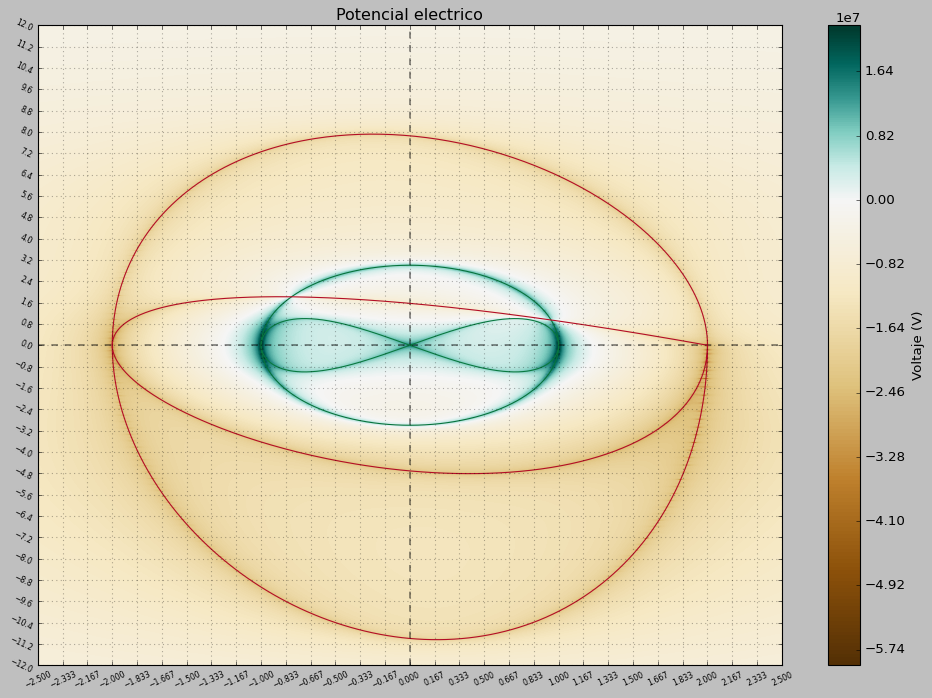

In [784]:
#-3.3.3 MALLA DE POTENCIAL ELECTRICO

#-------------------- CALCULO DE LA MALLA DEL POTENCIAL ELECTRICO --------------------

k = 501                                                                                                      #Numero de puntos que tendra la malla vectorial

x0 = -2.5                                                                                                    #Limites de la malla vectorial
x1 = 2.5
y0 = -12
y1 = 12

xi = np.linspace(x0, x1, k)                                                                                  #Creacion de las mallas en los ejes "X" y "Y"
yi = np.linspace(y0, y1, k)
X , Y = np.meshgrid(xi, yi)

X_puntos , Y_puntos , Potenciales = potencial_electrico_malla_p(Funcionespa , Intervalospa , Densidadespa , X , Y )
#---------- PARAMETROS PARA LA ASIGNACION DEL COLOR ----------

Coords = np.column_stack((X_puntos, Y_puntos))                                                               #Interpolacion de la malla de potencial con los puntos dados

V_malla = griddata(Coords, Potenciales, (X,Y), method="cubic")

#-------------------- GRAFICA DE LA MALLA DEL POTENCIAL ELECTRICO --------------------

#---------- PARAMETROS BASICOS PARA LA GRAFICA ----------

plt.style.use("classic")

plt.figure(figsize=(15, 10))
plt.title("Potencial electrico")

plt.xlim(x0 , x1)
plt.ylim(y0 , y1)

plt.axhline(0, ls="--", c="black", alpha=0.5 , linewidth=1.5)
plt.axvline(0, ls="--", c="black", alpha=0.5 , linewidth=1.5)

#---------- GRAFICACION DEL CAMPO VECTORIAL ----------

"""
Graficacion de la malla de potencial electrica dependiendo de los valores del potencial,
esto para fijar el cero sin color y que tenga una mejor visualizacion
"""

Vmin = min(Potenciales)
Vmax = max(Potenciales)

if Vmax >= 0 and Vmin >= 0:
    plt.contourf(X, Y, V_malla, 100, cmap=LinearSegmentedColormap.from_list("half_BrBG", cm.BrBG(np.linspace(0.5,1,256))), vmin=0, vmax=Vmax)
elif Vmax <= 0 and Vmin <= 0:
    plt.contourf(X, Y, V_malla, 1000, cmap=LinearSegmentedColormap.from_list("half_BrBG_pos", cm.BrBG(np.linspace(0, 0.5, 256))), vmin=Vmin, vmax=0)
else:
    Norma = TwoSlopeNorm(vmin=Vmin, vcenter = 0,vmax=Vmax)
    plt.contourf(X, Y, V_malla, 1000, cmap="BrBG", norm = Norma)

plt.colorbar(label="Voltaje (V)")

#---------- GRAFICACION DE LAS LINEAS CARGADAS ----------

for Funcion, Intervalo, Densidad in zip(Funcionespa, Intervalospa, Densidadespa):                                 #Se grafican todas las funciones dichas con un colormap para diferenciar magnitud lineal de carga

    Norma = SymLogNorm(linthresh=1e-16 , vmin=-1e-3, vmax=1e-3)
    Mapeo = cm.RdYlGn

    Color = Mapeo(Norma(Densidad))

    t = np.linspace(Intervalo[0], Intervalo[1], 1000)
    plt.plot(Funcion[0](t), Funcion[1](t) , color = Color )

#---------- PARAMETROS DE LA CUADRICULA ----------

plt.xticks(np.linspace(x0, x1, 31) , rotation=25)                                                                                #Se pone una cuadricula fina para mejor visualizacion de las escalas
plt.yticks(np.linspace(y0, y1, 31) , rotation=-25)

plt.tick_params(axis="both", labelsize=7) 
plt.grid(color="black", linewidth=1 , alpha=0.3, zorder=1)
plt.show()